#### Machine Learning

In [1]:
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../../data/full_spectrum_cleaning.csv")

In [3]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,0,200.00000,201210-1,Normal,134.816769
1,201210-1-00,1,200.68336,201210-1,Normal,132.968425
2,201210-1-00,2,201.36674,201210-1,Normal,131.193402
3,201210-1-00,3,202.05011,201210-1,Normal,129.491701
4,201210-1-00,4,202.73349,201210-1,Normal,127.863322
...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,210526-3,Hyperglycemia,21.219956
8023571,210526-3-09,2631,1997.94980,210526-3,Hyperglycemia,21.661414
8023572,210526-3-09,2632,1998.63330,210526-3,Hyperglycemia,22.127733
8023573,210526-3-09,2633,1999.31670,210526-3,Hyperglycemia,22.618911


In [4]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    statuses = df[['SpecID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

In [5]:
def evaluate_extra_trees(df):
    # Splitting the dataframe into features (X) and target variable (y)
    X = df.drop(['Status'], axis=1)
    y = df['Status']
    
    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using StratifiedKFold for classification tasks
    #cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)

    
    # Getting cross-validation scores
    scores = cross_val_score(et, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

In [6]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [7]:
wavelength_df.head()

,200.0,200.68336,201.36674,202.05011,202.73349,203.41685,204.10023,204.7836,205.46696,206.15034,...,1994.5331,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,134.816769,132.968425,131.193402,129.491701,127.863322,126.308264,124.826527,123.418112,122.083019,120.821247,...,24.994674,24.982150,24.964838,24.942738,24.915850,24.884173,24.847707,24.806453,24.760411,Normal
201210-1-01,189.848197,184.931000,180.201902,175.660903,171.308002,167.143200,163.166497,159.377893,155.777388,152.364981,...,47.838973,48.907376,50.011969,51.152751,52.329722,53.542882,54.792231,56.077769,57.399497,Normal
201210-1-02,289.485294,279.426356,269.704269,260.319031,251.270644,242.559106,234.184419,226.146581,218.445594,211.081456,...,180.722335,186.056710,191.493958,197.034078,202.677069,208.422933,214.271669,220.223277,226.277757,Normal
201210-1-03,541.015419,640.222323,735.399715,826.547596,913.665966,996.754824,1075.814172,1150.844008,1221.844333,1288.815147,...,22.563263,22.796259,23.043783,23.305835,23.582416,23.873525,24.179162,24.499327,24.834021,Normal
201210-1-04,133.264278,131.197621,129.204744,127.285645,125.440326,123.668786,121.971025,120.347044,118.796841,117.320418,...,25.129912,25.542866,25.969125,26.408690,26.861560,27.327736,27.807218,28.300005,28.806097,Normal


Show the performance of the current approach.

In [8]:
evaluate_extra_trees(wavelength_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.9494 +/- 0.0144


Fit an Extra Trees Classifier on the whole dataset.

In [9]:
# Splitting the dataframe into features (X) and target variable (y)
X = wavelength_df.drop(['Status'], axis=1)
y = wavelength_df['Status']

# Creating the Extra Trees classifier
et = ExtraTreesClassifier(random_state=1234)

et = ExtraTreesClassifier(random_state=1234)
et.fit(X, y)

ExtraTreesClassifier(random_state=1234)

In [10]:
feature_names = X.columns
importances = et.feature_importances_

# Creating a DataFrame from the feature names and importance
wavenumber_importance_df = pd.DataFrame({
    'WaveNumber': feature_names,
    'Importance': importances
})

wavenumber_importance_df

,WaveNumber,Importance
0,200.0,0.000467
1,200.68336,0.000862
2,201.36674,0.000462
3,202.05011,0.000379
4,202.73349,0.000935
...,...,...
2630,1997.2665,0.000326
2631,1997.9498,0.000444
2632,1998.6333,0.000640
2633,1999.3167,0.000432


In [11]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,0,200.00000,201210-1,Normal,134.816769
1,201210-1-00,1,200.68336,201210-1,Normal,132.968425
2,201210-1-00,2,201.36674,201210-1,Normal,131.193402
3,201210-1-00,3,202.05011,201210-1,Normal,129.491701
4,201210-1-00,4,202.73349,201210-1,Normal,127.863322
...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,210526-3,Hyperglycemia,21.219956
8023571,210526-3-09,2631,1997.94980,210526-3,Hyperglycemia,21.661414
8023572,210526-3-09,2632,1998.63330,210526-3,Hyperglycemia,22.127733
8023573,210526-3-09,2633,1999.31670,210526-3,Hyperglycemia,22.618911


Seaborn was using different axes so I used Matplotlib instead.

Text(0.5, 1.0, 'Feature Importance and Average Spectra of each Status')

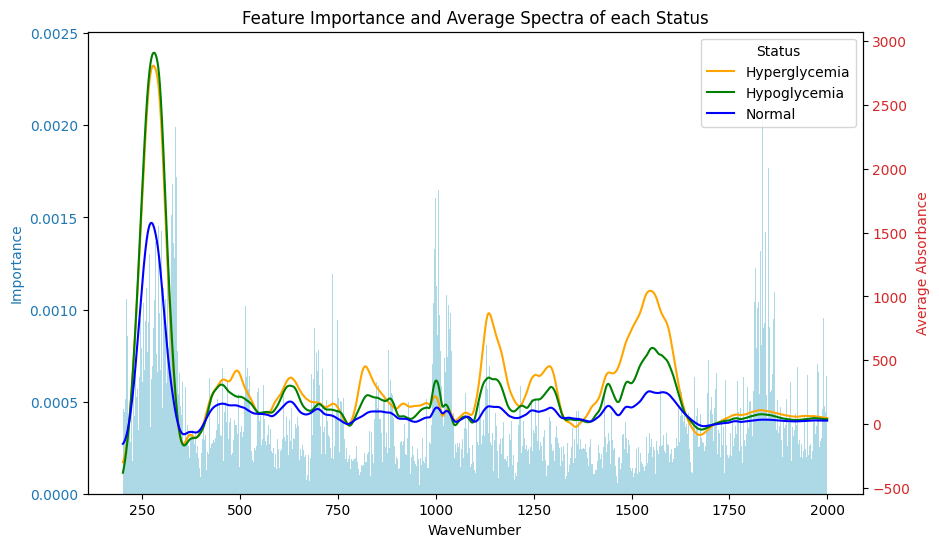

In [12]:
# Create the figure and the first (left) axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the bar plot on the first axis for Feature Importance
colors = ['lightblue'] * len(wavenumber_importance_df['WaveNumber'])
ax1.bar(wavenumber_importance_df['WaveNumber'], wavenumber_importance_df['Importance'], color=colors)
ax1.set_xlabel('WaveNumber')
ax1.set_ylabel('Importance', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create the second (right) axis, sharing the same x-axis
ax2 = ax1.twinx()

# Calculate average absorbance by WaveNumber and Status
avg_absorbance = df.groupby(['WaveNumber', 'Status'])['Absorbance'].mean().reset_index()

# Color mapping for 'Status'
color_map = {'Normal': 'blue', 'Hyperglycemia': 'orange', 'Hypoglycemia': 'green'}

# Plot average absorbance line plot on the second axis for each status
for status, group in avg_absorbance.groupby('Status'):
    ax2.plot(group['WaveNumber'], group['Absorbance'], label=status, color=color_map[status])

ax2.set_ylabel('Average Absorbance', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Adding legend for the line plots to distinguish between statuses
ax2.legend(title='Status')

# Title for the entire plot
plt.title('Feature Importance and Average Spectra of each Status')

# # Show the plot
# plt.tight_layout()
# plt.show()

#### **Cross-Val Importance**

Training the model on the whole dataset may be misleading, lets look at the average feature importance of each WaveNumber across the 10 folds.

In [13]:
from sklearn.model_selection import KFold

# Splitting the dataframe into features (X) and target variable (y)
X = wavelength_df.drop(['Status'], axis=1)
y = wavelength_df['Status']

# Creating the KFold object
cv = KFold(n_splits=10, shuffle=True, random_state=1234)

# Initialising an array to store feature importances across all folds
feature_importances = np.zeros(X.shape[1])

# Looping through each split
for train_index, test_index in cv.split(X, y):
    # Splitting the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Creating and fitting the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    et.fit(X_train, y_train)
    
    # Accumulating the feature importances
    feature_importances += et.feature_importances_

# Averaging the feature importances across all folds
feature_importances /= 10

# Creating a DataFrame from the feature names and their average importance
feature_names = X.columns
wavenumber_importance_df = pd.DataFrame({
    'WaveNumber': feature_names,
    'Importance': feature_importances
})

# Optionally, you might want to sort the DataFrame based on the importances
wavenumber_importance_df = wavenumber_importance_df.sort_values(by='Importance', ascending=False)

# Displaying the DataFrame
wavenumber_importance_df

,WaveNumber,Importance
1171,1000.2278,0.002022
1183,1008.4282,0.001998
2392,1834.6241,0.001887
194,332.57404,0.001802
182,324.37357,0.001757
...,...,...
1852,1465.6036,0.000131
851,781.54895,0.000131
1915,1508.656,0.000130
1913,1507.2893,0.000129


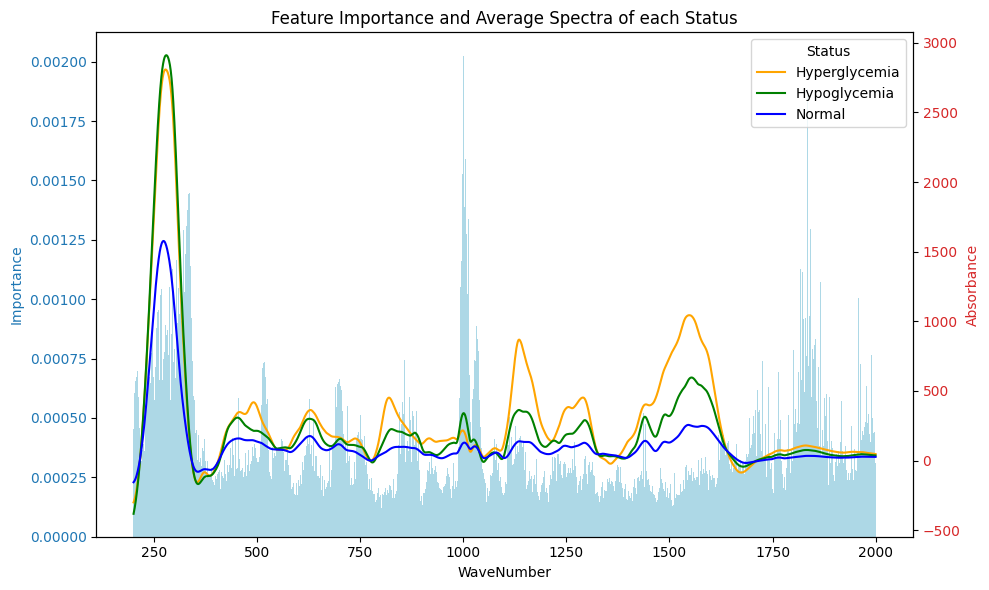

In [14]:
# Create the figure and the first (left) axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the bar plot on the first axis for Feature Importance
colors = ['lightblue'] * len(wavenumber_importance_df['WaveNumber'])
ax1.bar(wavenumber_importance_df['WaveNumber'], wavenumber_importance_df['Importance'], color=colors)
ax1.set_xlabel('WaveNumber')
ax1.set_ylabel('Importance', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create the second (right) axis, sharing the same x-axis
ax2 = ax1.twinx()

# Calculate average absorbance by WaveNumber and Status
avg_absorbance = df.groupby(['WaveNumber', 'Status'])['Absorbance'].mean().reset_index()

# Color mapping for 'Status'
color_map = {'Normal': 'blue', 'Hyperglycemia': 'orange', 'Hypoglycemia': 'green'}

# Plot average absorbance line plot on the second axis for each status
for status, group in avg_absorbance.groupby('Status'):
    ax2.plot(group['WaveNumber'], group['Absorbance'], label=status, color=color_map[status])

ax2.set_ylabel('Absorbance', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Adding legend for the line plots to distinguish between statuses
ax2.legend(title='Status')

# Title for the entire plot
plt.title('Feature Importance and Average Spectra of each Status')

# # Show the plot
plt.tight_layout()
plt.show()